# `tutorial_1`
# A hands-on introduction to fitting

In this tutorial you will learn how to fit simulated and data samples produced by the LHCb experiment at CERN. 

We will start by looking at the decay channel $B^+ \to J/\psi K^+$, a "standard candle" decay channel owing it its characteristically high signal statistics and purity. 

The oroginal data and Monte Carlo (MC) simulations have been originally made available by Dr Patrizia de Simone, at LNFN Frascati, Italy. Many thanks to the $R(D_s^*)$ LHCb team for sharing such datasets with us.

In [1]:
# basic imports; we will exploit many useful bespoke functions living in /utils/
from utils import load_ntuple, load_root, read_config  # I/O
from utils import (
    simple_ax,
    plot_data,
    save_to,
    viz_signal,
    hist_err,
    hist_step_fill,
    fill_hist_w,
    make_legend,
    eff_plot,
)  # plotting to publication standard
from utils import (
    pdf_factory,
    cdf_factory,
    SanityChecks,
    pdf_factory,
    composite_pdf_factory,
    composite_cdf_factory,
    twoclass_cdf,
    twoclass_pdf,
)  # fitting

# import standard python modules
from iminuit import cost, Minuit
import awkward as ak
import pandas as pd
import numpy as np

In [2]:
# define some global variables

# this is an auxiliary function to define a preliminary cleanup of the datasets
data_selection = (
    lambda m_min, m_max: f"((muplus_L0MuonDecision_TOS==1) | (muminus_L0MuonDecision_TOS==1)) \
            & (B_M>{m_min}) \
            & (B_M<{m_max})"
)

# pep8 for immutables
# number of mins considered in the NLL minimisation in the fit
FIT_BINS = 40
PLOT_BINS = 100
MRANGE = (5200, 5400) # considered beauty mass range, in MeV/c^2 -> see https://en.wikipedia.org/wiki/B_meson; you are interested in B+ mesons (two-quark states

# branches of interest
BRANCHES = [
    "B_M", # beauty invariant mass sprectum
]

The following two cells allow us to skim and write-to-file data and MC that are access-restricted. I place these here for bookeeping, but Amir and Kevin will receive the `.pkl` file separately via a private channel. 

In [3]:
# read in the config file parameters to source data from access-restricted remote locations (LHCb members only)
_mc_path = read_config(path="config.yml", key="misc")["eos_path_b2jsik_mc16_md"]
_data_path = read_config(path="config.yml", key="misc")["eos_path_b2jsik_data16_md"]

In [4]:
# skim remote MC file and write to /scratch/
# ------------------------------------------
# technicality: truthmatching 
mc_sel = f"{data_selection(*MRANGE)} \
    & (abs(B_TRUEID)==521) & (Jpsi_TRUEID==443) & (abs(Jpsi_MC_MOTHER_ID)==521) & (abs(muplus_TRUEID)==13) & (muplus_MC_MOTHER_ID==443) & (abs(muminus_TRUEID)==13) & (muminus_MC_MOTHER_ID==443) & (abs(K_TRUEID)==321) & (abs(K_MC_MOTHER_ID)==521)"

# load the file 
_mc = load_ntuple(
    file_path=f"root://eoslhcb.cern.ch/{_mc_path}",
    key="B2DsMuNuTuple",
    tree_name="DecayTree",
    max_entries=-1,
    branches=BRANCHES,
    cut=mc_sel,
)

# convert to pandas for ease of use and write to pkl for persistence
mc = ak.to_dataframe(_mc)
mc.to_pickle("scratch/b2jpsik_mc16_md.pkl")


# now execute the same, but for data
# ----------------------------------
data = load_root(
    file_path=f"root://eoslhcb.cern.ch/{_data_path}",
    key="B2DsMuNuTuple",
    tree_name="DecayTree",
    library="pd",
    max_entries=-1,
    branches=["B_M"],
    cut=data_selection(*MRANGE),  # make sure we don't include Bc decays
)
data.to_pickle("scratch/b2jpsik_data16_md.pkl")


SUCCESS: loaded with 300740 entries
'load_ntuple' execution completed in 3.6281 secs



Batches loaded: 100%|###########################################| 1/1 [00:01<00:00,  1.49s/it]


SUCCESS: loaded with 413434 entries


In [5]:
# load the data and mc dataset from the .pkl files
LOCAL_DATA_DIR = "scratch" # either place data here or amend to match custom location
MC = pd.read_pickle(f"{LOCAL_DATA_DIR}/b2jpsik_mc16_md.pkl")
DATA = pd.read_pickle(f"{LOCAL_DATA_DIR}/b2jpsik_data16_md.pkl")

OK, all going well, you have at your figertips your first-ever data and MC samples by LHCb. Congrats! 

Now, let us look at the distributions of the beauty-particle ($B^+$) in data and MC simulation, to get a feeling of what's going on:

Text(0.5, 0, 'Beauty invariant mass, $m(J/\\psi K^+)$ [MeV$/c^2$]')

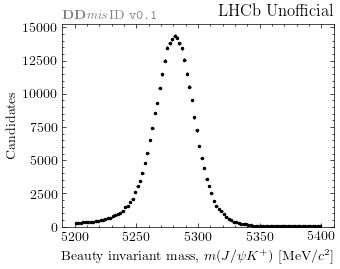

In [6]:
# let's look at MC first - these are *signal-only* simulated events
# -----------------------------------------------------------

# book a canvas for the plot
fig, ax = simple_ax()

# plot the simulated bin counts, with the error being the sqrt(bin content) - we assume Poisson stats in the high-stats limit
plot_data(
    data=MC.B_M,
    range=MRANGE,
    bins=PLOT_BINS,
    ax=ax,
    label="Simulation 2016",
)
ax.set_ylim(bottom=0)
ax.set_xlabel(r"Beauty invariant mass, $m(J/\psi K^+)$ [MeV$/c^2$]")

Did you inspect the wiki page on $B^+$ mesons? How does this mass interval (and resonance) compare with the relevant nominal mass value?

The logo `DDmisID` is due to the recycled code from a python module I am developing. Kevin will help me get it done.

Text(0.5, 0, 'Beauty invariant mass, $m(J/\\psi K^+)$ [MeV$/c^2$]')

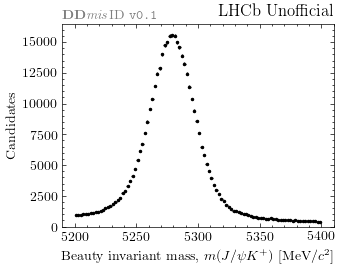

In [7]:
# now let's look at the data
# --------------------------

# book a canvas for the plot
fig, ax = simple_ax()

# plot the LHCb-reconstructed bin counts, with the error being the sqrt(bin content) - we assume Poisson stats in the high-stats limit
plot_data(
    data=DATA.B_M,
    range=MRANGE,
    bins=PLOT_BINS,
    ax=ax,
    label="Data 2016",
)
ax.set_ylim(bottom=0)
ax.set_xlabel(r"Beauty invariant mass, $m(J/\psi K^+)$ [MeV$/c^2$]")

Notice how this distribution is "fatter" on both sides; modelling these days, apart from the signal "bump" at the centre, is the challenge of this first stage of the tutorial. Also, note that there is some quasi-uniform background on top of which the bump is placed. This is a background, called "combinatorial. We will discuss this in our next meeting.  

The (limited! hence the adoption of this particular decay channel) abundance of backgrounds is due to a) imperfect detector effects (Kevin's focus); b) irreducible effects that should just be minimised at much as possible (Amir's focus).

## Fitting the simulated dataset

We will deplot the `iminuit` machinery. I expect you to have tried some basic tutorial. Let's start simple and get our hands dirty progressively.  


This stage of the tutorial amounts to exploting the MC sample to obtain a reliable description of the signal component in data. We shall use, effectively a mixture of analytical functions: 
- a [Gaussian function](https://en.wikipedia.org/wiki/Gaussian_function) to model the "core" of the signal;
- a series of [Crystal Ball functions](https://en.wikipedia.org/wiki/Crystal_Ball_function), to model energy-lossy processes as the mass of the beauty decay process nears the nominal mass value of the $B^+$ resonance 

The functions are handily defined in `utils/source.py`in `pdf_factory` for our convenience. For the time being, please try to understand the individual functions and let's see if it _does_ model the signal. 


In [8]:
# define the signal pdf -> https://en.wikipedia.org/wiki/Probability_density_function
dcbgauss_pdf = pdf_factory(mrange=MRANGE, key="signal")

# define the signal cdf -> https://en.wikipedia.org/wiki/Cumulative_distribution_function
dcbgauss_cdf = cdf_factory(mrange=MRANGE, key="signal")

Now we provide the data points (ie mass-bin counts) that we want to construct a cost function from. 

In [9]:
 # minimise the cost [https://iminuit.readthedocs.io/en/stable/notebooks/cost_functions.html#Binned-Fit]
nh, xe = np.histogram(MC["B_M"].to_numpy(), bins=FIT_BINS, range=MRANGE)

Now, we are simply interested in learning the parameters of the signal pdf, not it's yield. A simple [binned negative log-likelihood](https://iminuit.readthedocs.io/en/stable/notebooks/binned_vs_unbinned.html) fit will suffice.

In [10]:
cost_obj = cost.BinnedNLL(nh, xe, dcbgauss_cdf)

Now let's define the free parameter ranges and initialisation values.  

You can get a feeling of what these parameters are by looking at the source code in `utils/models.py` and the respective definitions in the `scipy` docs.

In [11]:
# build the Minuit object handling the cost minimisation -> identifty the parameter values that yield the best agreement with the data
mi = Minuit(
    cost_obj,
    f1=0.3,
    f2=0.5,
    mug=6275,
    sgg=20,
    sgl=20,
    sgr=20,
    al=1,
    ar=1,
    nl=10,
    nr=10,
)

# define the parameter ranges
mi.limits["f1"] = (0, 1)
mi.limits["f2"] = (0, 1)
mi.limits["mug"] = (5200, 5400)
mi.limits["sgg"] = (0, 50)
mi.limits["sgl"] = (0, 50)
mi.limits["sgr"] = (0, 50)
mi.limits["al"] = (0, 10)
mi.limits["ar"] = (0, 10)
mi.limits["nl"] = (0, 20)
mi.limits["nr"] = (0, 20)

In [12]:
# execute the cost minimisation and the error estimation 
# -> see https://iminuit.readthedocs.io/en/stable/notebooks/basic.html#Basics for basic (and sufficient) info
# -> see https://iminuit.readthedocs.io/en/stable/notebooks/hesse_and_minos.html for more details (if enthusiastic ;-) )
mi.migrad()
mi.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 43.43 (chi2/ndof = 1.4)    │             Nfcn = 1791              │
│ EDM = 0.0014 (Goal: 0.0002)      │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ f1   │   0.28    │   0.04    │            │            │    0    │    1    │       │
│ 1 │ f2   │   0.29    │   0.04    │            │            │    0    │    1    │       │
│ 2 │ mug  │ 5.28106e3 │ 0.00008e3 │            │            │  5200   │  5400   │       │
│ 3 │ sgg  │   19.5    │    0.6    │            │            │    0    │   50    │       │
│ 4 │ sgl  │   15.2    │    0.6    │            │            │    0    │   50    │       │
│ 5 │ sgr  │   13.83   │   0.22    │            │            │    0    │   50    │       │
│ 6 │ al   │   0.72    │   0.13    │            │            │    0    │   10    │       │
│ 7 │ ar   │   1.70    │   0.14    │            │            │    0    │   10    │       │
│ 8 │ nl   │    4.0    │    1.6    │            │            │    0    │   20    │       │
│ 9 │ nr   │    3.6    │    0.6    │            │            │    0    │   20    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│     │       f1       f2      mug      sgg      sgl      sgr       al       ar       nl       nr │
├─────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│  f1 │  0.00157  -0.0009   0.0016  -0.0129   -0.012 -0.00645 -0.00257 -0.00078   0.0123 -0.00187 │
│  f2 │  -0.0009  0.00178 -0.00163 0.000167 -0.00317  0.00519  0.00501 -0.00287  -0.0432   0.0124 │
│ mug │   0.0016 -0.00163  0.00586   -0.019  -0.0184 -0.00449 -0.00657 -0.00107   0.0622  0.00427 │
│ sgg │  -0.0129 0.000167   -0.019    0.401    0.119   0.0395    0.028   0.0698   -0.423   -0.274 │
│ sgl │   -0.012 -0.00317  -0.0184    0.119    0.325   -0.004  -0.0116   0.0356     0.36   -0.117 │
│ sgr │ -0.00645  0.00519 -0.00449   0.0395   -0.004   0.0476   0.0155 -0.00322   -0.142   0.0424 │
│  al │ -0.00257  0.00501 -0.00657    0.028  -0.0116   0.0155   0.0178  -0.0031   -0.195   0.0104 │
│  ar │ -0.00078 -0.00287 -0.00107   0.0698   0.0356 -0.00322  -0.0031   0.0186 -0.00021  -0.0794 │
│  nl │   0.0123  -0.0432   0.0622   -0.423     0.36   -0.142   -0.195 -0.00021      2.7   0.0859 │
│  nr │ -0.00187   0.0124  0.00427   -0.274   -0.117   0.0424   0.0104  -0.0794   0.0859    0.383 │
└─────┴───────────────────────────────────────────────────────────────────────────────────────────┘

### Challenge

Go head and try to unpack this info. What is it telling me?

In [13]:
# I typically implement a wrapper sanity checker myself. You can see its definition in utils/fit.py
SanityChecks(mi)()

Minuit fmin is valid
Minuit fmin has accurate covariance matrix


Congrats! Looks like the fit has converged and the sanity checks have passed (can you tell me what I should keep an eye for to judge the sanity of the fit?) 

To conclude this first installment, let us look at the fit result. Next time we will start modelling the aforementioned combinatorial. The time after that, you'll have an attempt at fitting the full data spectrum!

Text(0.5, 0, 'Beauty invariant mass, $m(J/\\psi K^+)$ [MeV$/c^2$]')

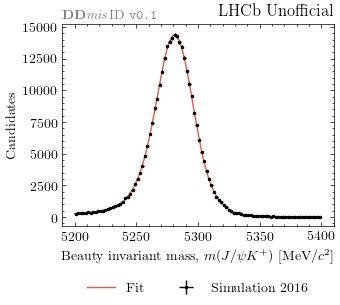

In [14]:
# viz results
# -----------
fig, ax = simple_ax()

# fit model; handle the norm of the pdf
nhp, _ = np.histogram(MC.B_M, range=MRANGE, bins=PLOT_BINS)
_norm = np.sum(nhp) * (MRANGE[1] - MRANGE[0]) / PLOT_BINS
_x = np.linspace(*MRANGE, PLOT_BINS)
viz_signal(x=_x, y=_norm * dcbgauss_pdf(_x, *mi.values), ax=ax)(label="Fit")

# observation
plot_data(
    data=MC.B_M,
    range=MRANGE,
    bins=PLOT_BINS,
    ax=ax,
    label="Simulation 2016",
)
# cosmetics & save
make_legend(ax=ax, on_plot=False, ycoord=-.4)
ax.set_xlabel(r"Beauty invariant mass, $m(J/\psi K^+)$ [MeV$/c^2$]")

End of `tutorial-1.0`

---